# Movebank Data Analysis Attempt

## Part 1

### Checking up the data and 1st Degree Clean-up: Identify the Useful Columns

After downloading the data, I found that the package came with two csv files. First, we can import the two tables - reference and Argos. To do so, we will have to import pandas (and numpy, for easier use later).

In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Read the reference table

In [2]:
whale_ref = pd.read_csv("../data/Blue_whales_reference.csv")
whale_ref.head()

,tag-id,animal-id,animal-taxon,deploy-on-date,deploy-off-date,animal-life-stage,animal-sex,attachment-type,deploy-on-latitude,deploy-on-longitude,deployment-id,manipulation-type,study-site,tag-manufacturer-name,tag-model,tag-readout-method
0,1993CA-ST6-10823,1993CA-Bmu-10823,Balaenoptera musculus,1993-08-28 18:20:00.000,1993-09-01 22:35:12.000,adult,,implant,37.012,-122.412,1993CA-10823,none,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6,satellite
1,1993CA-ST6-10833,1993CA-Bmu-10833,Balaenoptera musculus,1993-08-28 18:54:00.000,1993-08-28 21:45:56.000,adult,,implant,37.022,-122.415,1993CA-10833,none,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6,satellite
2,1993CA-ST6-00834,1993CA-Bmu-00834,Balaenoptera musculus,1993-08-29 01:13:00.000,1993-09-05 13:41:06.000,adult,,implant,37.058,-122.433,1993CA-00834,none,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6,satellite
3,1993CA-ST6-10836,1993CA-Bmu-10836,Balaenoptera musculus,1993-08-31 23:40:00.000,1993-09-04 16:35:40.000,adult,,implant,37.198,-122.773,1993CA-10836,none,"Pigeon Point, CA","Telonics, Inc",ST6,satellite
4,1994CA-ST10-10821,1994CA-Bmu-10821,Balaenoptera musculus,1994-09-13 20:31:00.000,1994-09-14 00:23:34.000,adult,,implant,37.600,-123.000,1994CA-10821,none,"Farallon Islands, CA","Telonics, Inc",ST10,satellite


In [3]:
whale_ref.shape

(143, 16)

The reference table records the information of each blue whale monitore. It is of size 143 rows x 16 columns. Let's figure out what each column is about.

In [4]:
whale_ref.columns

Index(['tag-id', 'animal-id', 'animal-taxon', 'deploy-on-date',
       'deploy-off-date', 'animal-life-stage', 'animal-sex', 'attachment-type',
       'deploy-on-latitude', 'deploy-on-longitude', 'deployment-id',
       'manipulation-type', 'study-site', 'tag-manufacturer-name', 'tag-model',
       'tag-readout-method'],
      dtype='object')

Combined with the column information provided in the README.txt file, we can find a few columns that provide informations that will be useful to us 
- *amimal-id*: An individual identifier for the subjects monitored
- *deploy-on-date* & *deploy-off-date*: the start and end time of monitoring
- *deploy-on-latitude* & *deploy-on-longitutde*: the start location of monitoring
- *study-site*: name of deployment site/facility

Before we downsize the table to a more concise version, let's check if the some standard measures (i.e. other less interesting columns) are uniform for each subject recorded.

In [5]:
whale_ref.groupby(['animal-life-stage','animal-taxon','attachment-type',
                   'manipulation-type','tag-readout-method']).count()

,,,,,tag-id,animal-id,deploy-on-date,deploy-off-date,animal-sex,deploy-on-latitude,deploy-on-longitude,deployment-id,study-site,tag-manufacturer-name,tag-model
animal-life-stage,animal-taxon,attachment-type,manipulation-type,tag-readout-method,,,,,,,,,,,
adult,Balaenoptera musculus,implant,none,satellite,143,143,143,143,143,143,143,143,143,143,143


In [6]:
whale_ref.groupby(['tag-manufacturer-name','tag-model']).count()

tag-id  animal-id  animal-taxon  \
tag-manufacturer-name   tag-model                                    
Telonics, Inc           ST10           15         15            15   
                        ST15          109        109           109   
                        ST21            6          6             6   
                        ST6            12         12            12   
Wildlife Computers, Inc MK10            1          1             1   

                                   deploy-on-date  deploy-off-date  \
tag-manufacturer-name   tag-model                                    
Telonics, Inc           ST10                   15               15   
                        ST15                  109              109   
                        ST21                    6                6   
                        ST6                    12               12   
Wildlife Computers, Inc MK10                    1                1   

                                   animal-life-stage  animal-sex  \
tag-manufacturer-name   tag-model                                  
Telonics, Inc           ST10                      15          15   
                        ST15                     109         109   
                        ST21                       6           6   
                        ST6                       12          12   
Wildlife Computers, Inc MK10                       1           1   

                                   attachment-type  deploy-on-latitude  \
tag-manufacturer-name   tag-model                                        
Telonics, Inc           ST10                    15                  15   
                        ST15                   109                 109   
                        ST21                     6                   6   
                        ST6                     12                  12   
Wildlife Computers, Inc MK10                     1                   1   

                                   deploy-on-longitude  deployment-id  \
tag-manufacturer-name   tag-model                                       
Telonics, Inc           ST10                        15             15   
                        ST15                       109            109   
                        ST21                         6              6   
                        ST6                         12             12   
Wildlife Computers, Inc MK10                         1              1   

                                   manipulation-type  study-site  \
tag-manufacturer-name   tag-model                                  
Telonics, Inc           ST10                      15          15   
                        ST15                     109         109   
                        ST21                       6           6   
                        ST6                       12          12   
Wildlife Computers, Inc MK10                       1           1   

                                   tag-readout-method  
tag-manufacturer-name   tag-model                      
Telonics, Inc           ST10                       15  
                        ST15                      109  
                        ST21                        6  
                        ST6                        12  
Wildlife Computers, Inc MK10                        1

Although most of the housekeeping columns have only one entry for all the rows (subjects), __the tag-model used for each subject is not exactly the same__ - most of which are ST15, and a few are of a slightly different model. __Will this create some problem for the data collected?__ We will find out later!

Now let's clean up our reference table for further use. 

In [7]:
whale_ref_clean = whale_ref[["animal-id","deploy-on-date","deploy-off-date",
                             "deploy-on-latitude","deploy-on-longitude","study-site",
                             "tag-manufacturer-name","tag-model"]]
whale_ref_clean.head(3)

,animal-id,deploy-on-date,deploy-off-date,deploy-on-latitude,deploy-on-longitude,study-site,tag-manufacturer-name,tag-model
0,1993CA-Bmu-10823,1993-08-28 18:20:00.000,1993-09-01 22:35:12.000,37.012,-122.412,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6
1,1993CA-Bmu-10833,1993-08-28 18:54:00.000,1993-08-28 21:45:56.000,37.022,-122.415,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6
2,1993CA-Bmu-00834,1993-08-29 01:13:00.000,1993-09-05 13:41:06.000,37.058,-122.433,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6


Now let's move on to the juicer table! Repeat the same procedure done to the reference table.

In [8]:
whale_data = pd.read_csv("../data/Blue_whales_Argos.csv")
whale_data.head(3)

,event-id,visible,timestamp,location-long,location-lat,argos:best-level,argos:calcul-freq,argos:iq,argos:lat1,argos:lat2,...,argos:lon1,argos:lon2,argos:nb-mes,argos:nb-mes-120,manually-marked-outlier,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name
0,9018011221,True,1993-08-29 01:13:00.000,-122.433,37.058,NaN,NaN,NaN,37.058,NaN,...,-122.433,NaN,NaN,NaN,NaN,gps,Balaenoptera musculus,1993CA-ST6-00834,1993CA-Bmu-00834,Blue whales Eastern North Pacific 1993-2008 - ...
1,9018011222,True,1993-08-28 18:20:00.000,-122.412,37.012,NaN,NaN,NaN,37.012,NaN,...,-122.412,NaN,NaN,NaN,NaN,gps,Balaenoptera musculus,1993CA-ST6-10823,1993CA-Bmu-10823,Blue whales Eastern North Pacific 1993-2008 - ...
2,9018011223,True,1993-08-28 18:54:00.000,-122.415,37.022,NaN,NaN,NaN,37.022,NaN,...,-122.415,NaN,NaN,NaN,NaN,gps,Balaenoptera musculus,1993CA-ST6-10833,1993CA-Bmu-10833,Blue whales Eastern North Pacific 1993-2008 - ...


In [9]:
whale_data.shape

(16249, 21)

In [10]:
whale_data.columns

Index(['event-id', 'visible', 'timestamp', 'location-long', 'location-lat',
       'argos:best-level', 'argos:calcul-freq', 'argos:iq', 'argos:lat1',
       'argos:lat2', 'argos:lc', 'argos:lon1', 'argos:lon2', 'argos:nb-mes',
       'argos:nb-mes-120', 'manually-marked-outlier', 'sensor-type',
       'individual-taxon-canonical-name', 'tag-local-identifier',
       'individual-local-identifier', 'study-name'],
      dtype='object')

Combined with the column information provided in the README.txt file, we can find a few columns that provide informations that will be useful to us 
- *timestamp*: The time point that a sensory measurement was taken
- *locaetion-long* & *location-lat*: the start location of monitoring
- *individual-local-identifier*: same as "animal-id" in reference table
- *manually-marked-outlier*: marked TRUE if "visible" marked FALSE

Some other technical measure associated with satellite signal receiving process that may be helpful for us to measure/visualize the credulity of data: 
- *argos:best-level*: Best signal strength
- *argos:calcul-freq*: Calculated frequency
- *argos:iq*: indicates transmitter oscillator frequency drift between two satellite passe
- *argos:nb-mes-120*: The number of messages received by the satellite at a signal strength greater than -120 decibels
- *sensor-type*: type of tracking sensor used (also appeared in reference table)



After identifying what we need and do not need, let us do some clean up and re-naming.

In [11]:
whale_data_clean = whale_data[['individual-local-identifier','timestamp','location-lat', 
                               'location-long', 'manually-marked-outlier','argos:best-level', 
                               'argos:calcul-freq', 'argos:iq','argos:nb-mes',
                               'argos:nb-mes-120', 'sensor-type']]
whale_data_clean.columns = ['animal-id','timestamp','location-lat', 'location-long', 
                               'outlier','argos:best-level', 'argos:calcul-freq', 'argos:iq',
                               'argos:no-mes-rec','argos:no-mes-rec-120', 'sensor-type']
whale_data_clean.head()

,animal-id,timestamp,location-lat,location-long,outlier,argos:best-level,argos:calcul-freq,argos:iq,argos:no-mes-rec,argos:no-mes-rec-120,sensor-type
0,1993CA-Bmu-00834,1993-08-29 01:13:00.000,37.058,-122.433,NaN,NaN,NaN,NaN,NaN,NaN,gps
1,1993CA-Bmu-10823,1993-08-28 18:20:00.000,37.012,-122.412,NaN,NaN,NaN,NaN,NaN,NaN,gps
2,1993CA-Bmu-10833,1993-08-28 18:54:00.000,37.022,-122.415,NaN,NaN,NaN,NaN,NaN,NaN,gps
3,1993CA-Bmu-10836,1993-08-31 23:40:00.000,37.198,-122.773,NaN,NaN,NaN,NaN,NaN,NaN,gps
4,1994CA-Bmu-10820,1994-09-13 21:28:00.000,37.687,-123.102,NaN,NaN,NaN,NaN,NaN,NaN,gps


After cleaning up the movement data table, let's do some basic grouping and counting using __`pd.groupby`__. This allows us to understands the values in some of the parameters.

In [12]:
whale_data_clean.groupby('outlier').count()

,animal-id,timestamp,location-lat,location-long,argos:best-level,argos:calcul-freq,argos:iq,argos:no-mes-rec,argos:no-mes-rec-120,sensor-type
outlier,,,,,,,,,,
True,471,471,471,471,465,465,429,468,465,471


__Outlier__: There are 471 out of 16249 records marked as outlier.

In [13]:
whale_data_clean.groupby(['sensor-type']).count()

,animal-id,timestamp,location-lat,location-long,outlier,argos:best-level,argos:calcul-freq,argos:iq,argos:no-mes-rec,argos:no-mes-rec-120
sensor-type,,,,,,,,,,
argos-doppler-shift,16106,16106,16106,16106,471,15941,15910,15424,16021,15910
gps,143,143,143,143,0,0,0,0,0,0


__sensor-type__: most of the data were recorded using argos-doppler-shift method

### 2nd-Degree Clean-up: Marking and Erasing the Outliers

Reading more closely into the reference table, I noticed that there are some individuals who were deployed on the tracker very shortly before they were taken off. It is best to leave these individuals out of the focus of our attention. <br>
Therefore, I decided to make a column that marks the how long the tracker was planted on each individuals. To do this, I need to make some changes of the data type first.

In [14]:
whale_ref_clean.dtypes

animal-id                 object
deploy-on-date            object
deploy-off-date           object
deploy-on-latitude       float64
deploy-on-longitude      float64
study-site                object
tag-manufacturer-name     object
tag-model                 object
dtype: object

Note that __`deploy-on-date`__ and __`deploy-off-date`__ are of type __`object`__. We need to change them into type __`datetime`__ using function __`pd.to_datetime()`__.

In [15]:
whale_ref_clean['deploy-on-date'] = pd.to_datetime(whale_ref_clean['deploy-on-date'])
whale_ref_clean['deploy-off-date'] = pd.to_datetime(whale_ref_clean['deploy-off-date'])
whale_ref_clean.dtypes

/Users/s.n.zhou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/s.n.zhou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


animal-id                        object
deploy-on-date           datetime64[ns]
deploy-off-date          datetime64[ns]
deploy-on-latitude              float64
deploy-on-longitude             float64
study-site                       object
tag-manufacturer-name            object
tag-model                        object
dtype: object

In [16]:
whale_ref_clean.insert(3,'monitor-duration', 
                       whale_ref_clean['deploy-off-date'] 
                        - whale_ref_clean['deploy-on-date'])
whale_ref_clean.head(3)

,animal-id,deploy-on-date,deploy-off-date,monitor-duration,deploy-on-latitude,deploy-on-longitude,study-site,tag-manufacturer-name,tag-model
0,1993CA-Bmu-10823,1993-08-28 18:20:00,1993-09-01 22:35:12,4 days 04:15:12,37.012,-122.412,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6
1,1993CA-Bmu-10833,1993-08-28 18:54:00,1993-08-28 21:45:56,0 days 02:51:56,37.022,-122.415,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6
2,1993CA-Bmu-00834,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6


In [19]:
whale_ref_clean.dtypes

animal-id                         object
deploy-on-date            datetime64[ns]
deploy-off-date           datetime64[ns]
monitor-duration         timedelta64[ns]
deploy-on-latitude               float64
deploy-on-longitude              float64
study-site                        object
tag-manufacturer-name             object
tag-model                         object
dtype: object

Now that we have added column named __`monitor-duration`__, we can easily sort the reference table with respect to this characteristic.

In [17]:
whale_ref_clean.sort_values('monitor-duration')

,animal-id,deploy-on-date,deploy-off-date,monitor-duration,deploy-on-latitude,deploy-on-longitude,study-site,tag-manufacturer-name,tag-model
104,2006CA-Bmu-00825,2006-09-12 22:33:00,2006-09-13 00:51:40,0 days 02:18:40,34.056,-120.598,"San Miguel Island, CA","Telonics, Inc",ST15
1,1993CA-Bmu-10833,1993-08-28 18:54:00,1993-08-28 21:45:56,0 days 02:51:56,37.022,-122.415,"Pt. Ano Nuevo, CA","Telonics, Inc",ST6
4,1994CA-Bmu-10821,1994-09-13 20:31:00,1994-09-14 00:23:34,0 days 03:52:34,37.600,-123.000,"Farallon Islands, CA","Telonics, Inc",ST10
8,1994CA-Bmu-10824,1994-09-14 22:00:00,1994-09-15 04:03:58,0 days 06:03:58,37.745,-123.125,"Farallon Islands, CA","Telonics, Inc",ST10
127,2007CA-Bmu-00827,2007-09-09 20:51:00,2007-09-10 05:35:10,0 days 08:44:10,34.122,-120.048,"Santa Barbara Channel, CA","Wildlife Computers, Inc",MK10
19,1995CA-Bmu-23037,1995-09-11 18:06:00,1995-09-12 03:04:20,0 days 08:58:20,34.115,-120.084,"Santa Barbara Channel, CA","Telonics, Inc",ST10
6,1994CA-Bmu-10822,1994-09-13 22:35:00,1994-09-14 16:41:38,0 days 18:06:38,37.000,-123.400,"Offshore, Pigeon Point, CA","Telonics, Inc",ST10
32,1998CA-Bmu-01390,1998-08-28 22:04:00,1998-08-29 16:22:20,0 days 18:18:20,37.607,-123.054,"Farallon Islands, CA","Telonics, Inc",ST15
56,2000CA-Bmu-10823,2000-10-04 19:51:00,2000-10-05 15:23:29,0 days 19:32:29,37.620,-123.040,"Farallon Islands, CA","Telonics, Inc",ST15
12,1994CA-Bmu-23029,1994-10-07 17:27:00,1994-10-08 14:36:12,0 days 21:09:12,34.148,-119.938,"Santa Barbara Channel, CA","Telonics, Inc",ST6


From the sorted table above, we can see that the duration in which trackers were kept on a  blue whale range from 2 hours to 503 days! We would definitely remove the poor whales who only had the tracker on for a couple hours from our data :( Let's create a histogram to visualize the __`monitor-duration`__ column.

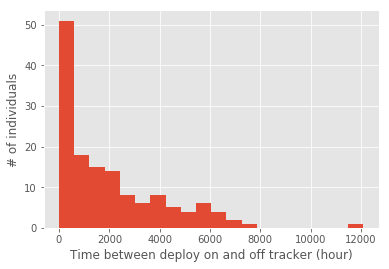

In [56]:
(whale_ref_clean['monitor-duration'] / pd.Timedelta(hours=1)).hist(bins = 20)
plt.xlabel('Time between deploy on and off tracker (hour)')
plt.ylabel('# of individuals');

It seems like that there are more than __50__ out of __143__ whales who wore the tracker for less than 12500 / 20 = 625 hours (about a month). Now let's look more closely on the portion below 480 hours (20 days)

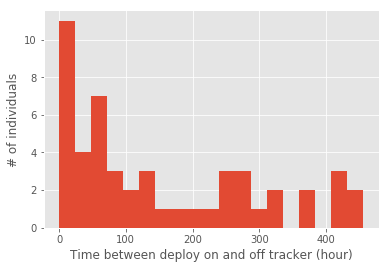

In [60]:
(whale_ref_clean['monitor-duration'] / pd.Timedelta(hours=1)).hist(bins = range(0, 480, 24))
plt.xlabel('Time between deploy on and off tracker (hour)')
plt.ylabel('# of individuals');

Judging from the zoomed-in histogram, it seems that there are 11 + 4 + 7 = 22 whales who wore the tracker for less than 72 hours (3 days) and need to be excluded from our data. 

Although we could go ahead and remove the outliers now, it would be more efficient if we cross reference with __`outliers`__ in the data table. To accomplish this, we need to merge the two tables into a big one using __`pd.merge`__.

In [52]:
whale = pd.merge(whale_data_clean,
                 whale_ref_clean[['animal-id', 'deploy-on-date', 'deploy-off-date', 
                                  'monitor-duration', 'deploy-on-latitude', 
                                  'deploy-on-longitude', 'study-site']],
                 on='animal-id')
whale = whale[['animal-id', 'timestamp', 'location-lat', 'location-long', 'outlier',
               'deploy-on-date', 'deploy-off-date', 'monitor-duration', 'deploy-on-latitude', 
               'deploy-on-longitude', 'study-site', 'sensor-type', 'argos:best-level', 
               'argos:calcul-freq','argos:no-mes-rec', 'argos:no-mes-rec-120']]
whale.head()

,animal-id,timestamp,location-lat,location-long,outlier,deploy-on-date,deploy-off-date,monitor-duration,deploy-on-latitude,deploy-on-longitude,study-site,sensor-type,argos:best-level,argos:calcul-freq,argos:no-mes-rec,argos:no-mes-rec-120
0,1993CA-Bmu-00834,1993-08-29 01:13:00.000,37.058,-122.433,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",gps,NaN,NaN,NaN,NaN
1,1993CA-Bmu-00834,1993-08-29 01:23:17.000,36.981,-122.407,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-126.0,4.016497e+08,4.0,0.0
2,1993CA-Bmu-00834,1993-08-31 13:04:34.000,37.637,-122.788,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-126.0,6.496602e+05,2.0,0.0
3,1993CA-Bmu-00834,1993-09-01 01:57:39.000,37.166,-122.827,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-129.0,6.496602e+05,2.0,0.0
4,1993CA-Bmu-00834,1993-09-05 13:41:06.000,38.231,-122.747,True,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-129.0,6.496602e+05,2.0,0.0


Once we have a merge table, we can select records that are 1) not marked an outlier, and 2) not from an whale wearing tracker for less than 3 days

In [70]:
whale_clean = whale.loc[(whale['outlier'] != True) 
                        & ((whale['monitor-duration']/pd.Timedelta(days=1)) > 72)]
whale_clean.head()

,animal-id,timestamp,location-lat,location-long,outlier,deploy-on-date,deploy-off-date,monitor-duration,deploy-on-latitude,deploy-on-longitude,study-site,sensor-type,argos:best-level,argos:calcul-freq,argos:no-mes-rec,argos:no-mes-rec-120
0,1993CA-Bmu-00834,1993-08-29 01:13:00.000,37.058,-122.433,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",gps,NaN,NaN,NaN,NaN
1,1993CA-Bmu-00834,1993-08-29 01:23:17.000,36.981,-122.407,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-126.0,4.016497e+08,4.0,0.0
2,1993CA-Bmu-00834,1993-08-31 13:04:34.000,37.637,-122.788,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-126.0,6.496602e+05,2.0,0.0
3,1993CA-Bmu-00834,1993-09-01 01:57:39.000,37.166,-122.827,NaN,1993-08-29 01:13:00,1993-09-05 13:41:06,7 days 12:28:06,37.058,-122.433,"Pt. Ano Nuevo, CA",argos-doppler-shift,-129.0,6.496602e+05,2.0,0.0
5,1993CA-Bmu-10823,1993-08-28 18:20:00.000,37.012,-122.412,NaN,1993-08-28 18:20:00,1993-09-01 22:35:12,4 days 04:15:12,37.012,-122.412,"Pt. Ano Nuevo, CA",gps,NaN,NaN,NaN,NaN


In [69]:
whale_clean.shape

-3582